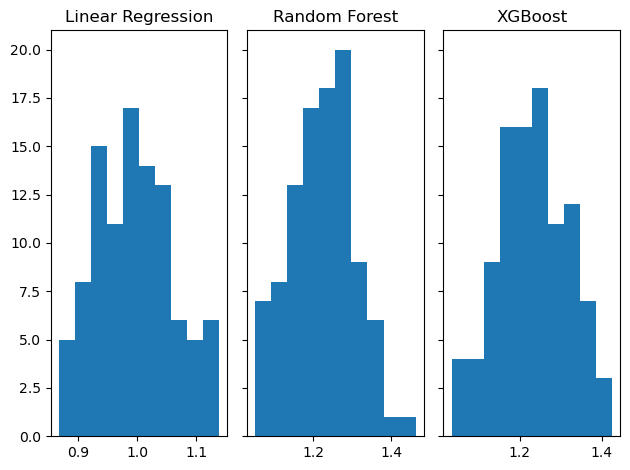

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Packages
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

# Parameters
S = 100 # Number of simulations
N = 1500 # Number of samples
N_train = 1000 # Number of training samples
# Dataframe to save mean of squared errors ﴾lm vs rf vs xgb﴿
simulation_index = list(range(S))
mse_lm = pd.DataFrame(index = simulation_index, columns = ["mse"])
mse_rf = pd.DataFrame(index = simulation_index, columns = ["mse"])
mse_xgb = pd.DataFrame(index = simulation_index, columns = ["mse"])
# Instantiate a random forest
rf = RandomForestRegressor(n_estimators = 250,
max_depth = 10,
random_state = 42)
# Instantiate a XGBoost
xgb_regressor = xgb.XGBRegressor(
objective = "reg:linear", # Specify the learning task
n_estimators = 100, # Number of trees in random forest to fit
reg_lambda = 1, # L2 regularization term
gamma = 0, # Minimum loss reduction
max_depth = 6, # Maximum tree depth
learning_rate = 0.3, # Learning rate, eta
verbosity = 0 # Ignore warnings
)
xgb_parm = xgb_regressor.get_xgb_params()
# Run simulation
for i in range(S):
    # Simulate predictors
    x = pd.DataFrame(np.random.normal(size = (N,2)),
    columns = ["x1", "x2"])
    # Simulate y ﴾don't forget to add the noise, epsilon﴿
    y = 1.5*x.x1 - 2*x.x2 + np.random.normal(size = N)
    # Training and test data split
    training_x = x.iloc[0:N_train]
    training_y = y.iloc[0:N_train]
    test_x = x.iloc[N_train:N]
    test_y = y.iloc[N_train:N]
    ## Linear regression
    # Train the model and make a prediction
    lm = LinearRegression().fit(training_x, training_y)
    lm_prediction = lm.predict(test_x)
    # Compute mean squared errors
    mse_lm.iloc[i] = mse(lm_prediction, test_y)
    ## Random forest
    # Train the model and make a prediction
    rf.fit(training_x, training_y)
    rf_prediction = rf.predict(test_x)
    # Compute mean squared errors
    mse_rf.iloc[i] = mse(rf_prediction, test_y)
    ## XGBoost
    # XGBoost uses Dmatrices
    xgb_train = xgb.DMatrix(training_x, label = training_y)
    # Cross‑validation
    xgb_cvresult = xgb.cv(params = xgb_parm,
    dtrain = xgb_train,
    num_boost_round = 20,
    metrics = "rmse",
    nfold = 10,
    stratified = False,
    seed = i+1234)
    # Update parameters ﴾# of trees﴿
    xgb_regressor.set_params(n_estimators = xgb_cvresult.shape[0])
    # Train the model
    xgb_regressor.fit(training_x, training_y)
    # Test the model
    xgb_prediction = xgb_regressor.predict(test_x,
    ntree_limit = xgb_cvresult.shape[0])
    # Compute the average of squared errors
    mse_xgb.iloc[i] = mse(xgb_prediction, test_y)
## Plotting histograms
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
# We can set the number of bins with the `bins` kwarg
n_bins = 10 # Total number of bins for histograms
axs[0].hist(mse_lm, bins=n_bins)
axs[0].set_title("Linear Regression")
axs[1].hist(mse_rf, bins=n_bins)
axs[1].set_title("Random Forest")
axs[2].hist(mse_xgb, bins=n_bins)
axs[2].set_title("XGBoost")
plt.show()

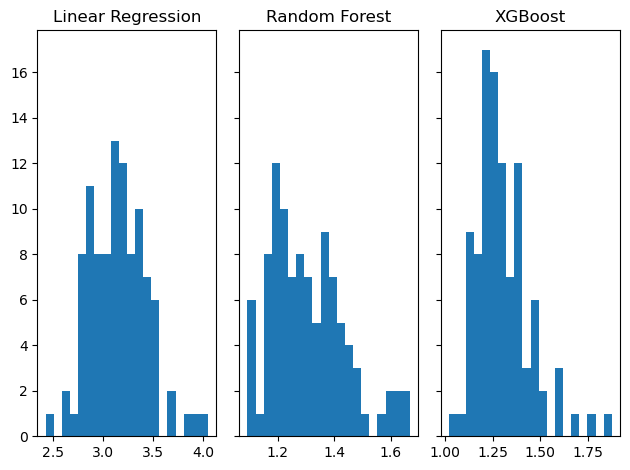

In [3]:
## Alternative models ﴾non‑linear version﴿
for i in range(S):
    # Simulate predictors
    x = pd.DataFrame(np.random.normal(size = (N,2)),
    columns = ["x1", "x2"])
    # Simulate y
    y = 1.5*x.x1 - 2*x.x2 + np.random.normal(size = N)
    y.loc[(x.x1 > 0)] = 1.5*np.log(x.x1) + np.random.normal(size = N)
    # Training and test data split
    training_x = x.iloc[0:N_train]
    training_y = y.iloc[0:N_train]
    test_x = x.iloc[N_train:N]
    test_y = y.iloc[N_train:N]
    ## Linear regression
    # Train the model and make a prediction
    lm = LinearRegression().fit(training_x, training_y)
    lm_prediction = lm.predict(test_x)
    # Compute mean squared errors
    mse_lm.iloc[i] = mse(lm_prediction, test_y)
    ## Random forest
    # Train the model and make a prediction
    rf.fit(training_x, training_y)
    rf_prediction = rf.predict(test_x)
    # Compute mean squared errors
    mse_rf.iloc[i] = mse(rf_prediction, test_y)
    ## XGBoost
    # XGBoost uses Dmatrices
    xgb_train = xgb.DMatrix(training_x, label = training_y)
    # Cross‑validation
    xgb_cvresult = xgb.cv(params = xgb_parm,
    dtrain = xgb_train,
    num_boost_round = 20,
    metrics = "rmse",
    nfold = 10,
    stratified = False,
    seed=i+1234)
    # Update parameters ﴾# of trees﴿
    xgb_regressor.set_params(n_estimators = xgb_cvresult.shape[0])
    # Train the model
    xgb_regressor.fit(training_x, training_y)
    # Test the model
    xgb_prediction = xgb_regressor.predict(test_x,
    ntree_limit = xgb_cvresult.shape[0])
    # Compute the average of squared errors
    mse_xgb.iloc[i] = mse(xgb_prediction, test_y)
## Plotting histograms
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
# We can set the number of bins with the `bins` kwarg
n_bins = 20 # Total number of bins for histograms
axs[0].hist(mse_lm, bins=n_bins)
axs[0].set_title("Linear Regression")
axs[1].hist(mse_rf, bins=n_bins)
axs[1].set_title("Random Forest")
axs[2].hist(mse_xgb, bins=n_bins)
axs[2].set_title("XGBoost")
plt.show()

In [5]:
boston = load_boston()
print(boston.DESCR)

# Set predictors and labels
X = pd.DataFrame(boston.data)
X.columns = boston.feature_names
y = pd.DataFrame(boston.target)
y.columns = ["Price"]
# Split train and test data
training_x, test_x, training_y, test_y = train_test_split(X, y,
test_size=0.2,
random_state=12345)
## 1. Random forest
# Train the model and make a prediction
rf.fit(training_x, training_y)
rf_prediction = rf.predict(test_x)
# Compute MSE
mse_rf_boston = mse(rf_prediction, test_y)
# Baseline MSE
mse_base_boston = np.mean(np.square((test_y - np.mean(test_y))))
# PseudoR2 for random forest
PseudoR2_rf = 1 - mse_rf_boston / mse_base_boston
print("Pseudo R2 for random forest is ", PseudoR2_rf)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
# Instantiate a XGBoost
xgb_regressor = xgb.XGBRegressor(
objective = "reg:linear", # Specify the learning task
n_estimators = 100, # Number of trees in random forest to fit
reg_lambda = 1, # L2 regularization term
gamma = 0, # Minimum loss reduction
max_depth = 6, # Maximum tree depth
learning_rate = 0.1, # Learning rate, eta
verbosity = 0 # Ignore warnings
)
xgb_parm = xgb_regressor.get_xgb_params()
# Cross‑validation
# XGBoost uses Dmatrices
xgb_train = xgb.DMatrix(training_x, label = training_y)
# Cross‑validation
xgb_cvresult = xgb.cv(params = xgb_parm,
dtrain = xgb_train,
num_boost_round = 200,
metrics = "rmse",
nfold = 10,
stratified = False,
seed=12345678)
# Update parameters ﴾# of trees﴿
xgb_regressor.set_params(n_estimators = xgb_cvresult.shape[0])
# Train the model
xgb_regressor.fit(training_x, training_y)
# Test the model
xgb_prediction_boston = xgb_regressor.predict(test_x,
ntree_limit = xgb_cvresult.shape[0])
# Compute the average of squared errors
mse_xgb_boston = mse(xgb_prediction_boston, test_y)
# PseudoR2 for XGBoost
PseudoR2_xgb = 1 - mse_xgb_boston / mse_base_boston
print("Pseudo R2 for XGBoost is ", PseudoR2_xgb)

Pseudo R2 for XGBoost is  Price    0.84717
dtype: float64


In [7]:
# Cross‑validation to find best alpha
elastic_cv = ElasticNetCV(cv = 4, l1_ratio = 0.5)
elastic_cv.fit(training_x, training_y)
# Get the best alpha
best_alpha = elastic_cv.alpha_
# Train the model and make a prediction
elastic = ElasticNet(alpha = best_alpha, l1_ratio = 0.5)
elastic.fit(training_x, training_y)
enet_prediction = elastic.predict(test_x)
# Compute MSE
mse_rf_enet = mse(enet_prediction, test_y)
# PseudoR2 for random forest
PseudoR2_enet = 1 - mse_rf_enet / mse_base_boston
print("Pseudo R2 for Elastic Net is ", PseudoR2_enet)

Pseudo R2 for Elastic Net is  Price    0.600398
dtype: float64


In [10]:
# Log transformation
log_var = ["INDUS", "RM", "RAD", "PTRATIO", "LSTAT"]
for var in log_var:
    training_x[var] = np.log(training_x[var])
    test_x[var] = np.log(test_x[var])
# Repeat the elastic net
# Train the model and make a prediction
elastic.fit(training_x, training_y)
enet_prediction2 = elastic.predict(test_x)
# Compute MSE
mse_rf_enet2 = mse(enet_prediction2, test_y)
# PseudoR2 for random forest with log transformation
PseudoR2_enet2 = 1 - mse_rf_enet2 / mse_base_boston
print("Pseudo R2 for elastic net with log transformation is ", PseudoR2_enet2)

Pseudo R2 for elastic net with log transformation is  Price    0.356338
dtype: float64
